<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## DSI-SG-42 Capstone Project:
## Ace Advantage: Serve Optimization for Tennis Players

> Authors: Ngan Han Kiong
---

**Background:**

Tennis, being a highly dynamic and skill-based sport, demands precision and efficiency in every aspect of play. Among these, the serve stands out as one of the most crucial shots, often dictating the flow and outcome of a match. Mastering the serve requires not only strength and technique but also a keen understanding of body positioning and movement.

Traditionally, coaches and players rely on subjective assessments or costly motion capture systems to analyze and optimize the tennis serve. However, recent advancements in computer vision and deep learning have opened up new possibilities for understanding human movement with remarkable accuracy and affordability.

**Problem Statement:** 

How might we develop a data-driven approach to analyze serve performance data and develop personalized strategies for optimizing serve accuracy, power, and placement, thereby empowering tennis players to enhance their on-court performance and gain a competitive edge in matches?

**Persona:**

Alex, a seasoned tennis coach, brings over 15 years of experience to the court. 
Passionate about player development, he seeks innovative, data-driven solutions to optimize serves and gain a competitive edge in tournaments. 
Alex's goal is to help players of all levels reach their full potential while staying ahead of industry trends and technology advancements. 
With a focus on enhancing serve accuracy, power, and placement, Alex navigates challenges and pressures to maintain his reputation as a top-tier coach, driven by a commitment to excellence and success on the court.

These are the notebooks for this project:  
 1. `01_Predicting_Tennis_Serve_Outcomes.ipynb`  
 2. `02_Pose_Detection_and_Analysis.ipynb`    

These are the sources that I have referenced for the project:
1. [New York Times article “The Toss”](https://www.nytimes.com/interactive/2022/08/28/sports/tennis/tennis-serve-ball-toss.html)
2. [Nick Kyrgios Serve Compilation | Includes Slow Motion | Tennis](https://www.youtube.com/watch?v=T4YlusgCKfs)
3. [TennisCraft Match Database](https://www.tenniscraft.nyc/match-database)
4. [Predicting tennis serves outcomes](https://www.youtube.com/watch?v=d3Z_eJfPACs)
5. [Can AI Make You a Better Athlete?](https://daleonai.com/machine-learning-for-sports)
6. [Tensorflow Multi-Person Pose Estimation with Python](https://github.com/nicknochnack/MultiPoseMovenetLightning)

To access the google drive resources (particularly the data as they are too large to be pushed to Github)
1. [Data for Project](https://drive.google.com/drive/folders/1-rfgudMgdzlRARMM11O5Pwyv5OCMrSbN?usp=sharing)
2. [Google Presentation Slides](https://docs.google.com/presentation/d/1B3hqbzvZrW1lGJH2OV1gwZYWhoBRvHCbmY4UTrwPCGM/edit?usp=sharing)
 ---

### Part 1 Predicting Tennis Serve Outcomes

For this part on predicting tennis serve outcomes, these are the sections:

1. Data collection
2. Data annotations
3. Frame extractions
4. Loading and Preprocessing of Frames
5. Modelling
6. Conclusions and Recommendations

---
### 1. Data Collection

The first step in the project is to collect the tennis serve data. In order to do this, I referenced to a dataset of structured point-by-point data provided by 'The Tennis Abstract Match Charting Project`. I used this dataset to randomly select matches and points to use as samples for the model. 

In [3]:
!git clone https://github.com/JeffSackmann/tennis_MatchChartingProject.git

Cloning into 'tennis_MatchChartingProject'...
remote: Enumerating objects: 1926, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 1926 (delta 243), reused 231 (delta 199), pack-reused 1648
Receiving objects: 100% (1926/1926), 518.30 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (1786/1786), done.
Updating files: 100% (45/45), done.


In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import PIL
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Reshape, InputLayer
from tensorflow.keras.layers import ConvLSTM2D, Dropout
from keras.layers import InputLayer
import random
import shutil
import tensorflow as tf
from tensorflow.keras.utils import plot_model

pd.set_option('display.max_columns', None)

2024-05-09 01:23:54.949177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Below are snippets of the match and point dataframes used to collect the data samples

In [2]:
df_matches_all = pd.read_csv('../tennis_MatchChartingProject/charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')
df_matches_all.head()

,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Gender,Date,Tournament,Round,Time,Court,Surface,Umpire,Best of,Final TB?,Charted by
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,Novak Djokovic,Ben Shelton,R,L,M,20230908,US Open,SF,3:15 PM,Ashe,Hard,L. Engzell,5,A,BG
1,20230905-M-US_Open-QF-Novak_Djokovic_-Taylor_F...,Novak Djokovic,Taylor Fritz,R,R,M,20230905,US Open,QF,1:50 PM,Ashe,Hard,D. Dumusois,5,A,BG
2,20230831-M-US_Open-R64-Hubert_Hurkacz-Jack_Draper,Hubert Hurkacz,Jack Draper,R,L,M,20230831,US Open,R64,11:10 AM,12,Hard,Greg Allensworth,5,A,Carrie
3,20230829-M-US_Open-R128-Hubert_Hurkacz-Marc_An...,Hubert Hurkacz,Marc Andrea Huesler,R,L,M,20230829,US Open,R128,5:55 PM,10,Hard,Scotty Moore,5,A,Carrie
4,20230829-M-US_Open-R128-Grigor_Dimitrov-Alex_M...,Grigor Dimitrov,Alex Molcan,R,L,M,20230829,US Open,R128,NaN,7,Hard,M. Veljovic,5,A,BG


I am only keeping the matches that are from 2010 to 2023 and thus dropping those matches that are older than 2010. 

In [3]:
# Convert match_id to datetime and extract the year
df_matches_all['Year'] = pd.to_datetime(df_matches_all['match_id'].str[:4], format='%Y')

# Filter rows based on the year
df_matches = df_matches_all[(df_matches_all['Year'] >= '2010') & (df_matches_all['Year'] <= '2023')]

# Drop the 'Year' column if no longer needed
df_matches = df_matches.drop(columns=['Year'])

# Display the filtered DataFrame
df_matches.head()


,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Gender,Date,Tournament,Round,Time,Court,Surface,Umpire,Best of,Final TB?,Charted by
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,Novak Djokovic,Ben Shelton,R,L,M,20230908,US Open,SF,3:15 PM,Ashe,Hard,L. Engzell,5,A,BG
1,20230905-M-US_Open-QF-Novak_Djokovic_-Taylor_F...,Novak Djokovic,Taylor Fritz,R,R,M,20230905,US Open,QF,1:50 PM,Ashe,Hard,D. Dumusois,5,A,BG
2,20230831-M-US_Open-R64-Hubert_Hurkacz-Jack_Draper,Hubert Hurkacz,Jack Draper,R,L,M,20230831,US Open,R64,11:10 AM,12,Hard,Greg Allensworth,5,A,Carrie
3,20230829-M-US_Open-R128-Hubert_Hurkacz-Marc_An...,Hubert Hurkacz,Marc Andrea Huesler,R,L,M,20230829,US Open,R128,5:55 PM,10,Hard,Scotty Moore,5,A,Carrie
4,20230829-M-US_Open-R128-Grigor_Dimitrov-Alex_M...,Grigor Dimitrov,Alex Molcan,R,L,M,20230829,US Open,R128,NaN,7,Hard,M. Veljovic,5,A,BG


In [4]:
df_points_2020s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2020s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')
df_points_2020s.head()

/var/folders/rt/p_ldfrxs2mlccmfw8h8bcyn00000gn/T/ipykernel_40921/617874344.py:1: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points_2020s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2020s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')


,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,6f2n#,NaN,Roof closed,0,NaN,1,NaN,False,False,False,True,False,False,1,1,1
1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0,0,15-0,1 (2),1,0,NaN,1,2,ND,4n,6b19f1b2s1f+3f2j2*,NaN,0,0.0,0,1.0,False,False,True,False,False,False,2,0,8
2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4d,4b+28f2o1*,NaN,0,0.0,0,1.0,False,False,True,False,False,False,2,0,4
3,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,4,0,0,0,0,15-30,1 (4),1,0,NaN,1,2,ND,6s28f3*,NaN,NaN,0,NaN,1,NaN,False,False,True,False,False,False,1,1,3
4,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,5,0,0,0,0,30-30,1 (5),1,0,NaN,1,2,ND,4b37b-3*,NaN,NaN,0,NaN,1,NaN,False,False,True,False,False,False,1,1,3


In [5]:
df_points_2010s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2010s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')
df_points_2010s.head()

/var/folders/rt/p_ldfrxs2mlccmfw8h8bcyn00000gn/T/ipykernel_40921/3349779608.py:1: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_points_2010s = pd.read_csv('../tennis_MatchChartingProject/charting-m-points-2010s.csv', quoting=csv.QUOTE_NONE, encoding='latin-1')


,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,1,0,0,0,0.0,0-0,1 (1),1,0,NaN,1,2,RN,4n,4b1b1b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,3
1,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,2,0,0,0,0.0,15-0,1 (2),1,0,NaN,1,2,RN,5n,5f28f2b1b1b2f3f3d@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,7
2,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,3,0,0,0,0.0,30-0,1 (3),1,0,NaN,1,2,RN,4C,NaN,NaN,0,NaN,1,NaN,False,False,False,False,False,False,1,1,1
3,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,4,0,0,0,0.0,40-0,1 (4),1,0,NaN,1,2,RN,4r2d#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,1
4,20191124-M-Davis_Cup_Finals-F-Rafael_Nadal-Den...,5,0,0,1,0.0,0-0,2 (1),1,0,NaN,2,1,DS,5d,c4b1b1d!@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,0,2


I am merging the two dataframes df_points_2020s and df_points_2010s to get the match points from 2010 to 2023. 

In [6]:
# Concatenate the DataFrames
df_points = pd.concat([df_points_2020s, df_points_2010s])

# Reset the index of the concatenated DataFrame
df_points.reset_index(drop=True, inplace=True)

# Display the merged DataFrame
df_points.tail()

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
551784,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,119,0,1,3,5.0,AD-40,19,1,0,NaN,1,2,RF,4d,4b3n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1.0
551785,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,120,0,1,4,5.0,0-0,20,1,0,NaN,2,1,ND,5d,6f1w#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,2,1,1.0
551786,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,121,0,1,4,5.0,15-0,20,1,0,NaN,2,1,ND,5s38b2f1f1f2b2b2f1f3b3b+1n@,NaN,NaN,0,NaN,1,NaN,False,False,False,False,True,False,2,1,11.0
551787,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,122,0,1,4,5.0,30-0,20,1,0,NaN,2,1,ND,4f18f1f3b3s3b3s3f+1l1o3*,NaN,NaN,0,NaN,1,NaN,False,False,True,False,False,False,2,1,11.0
551788,20100108-M-Doha-SF-Roger_Federer-Nikolay_Davyd...,123,0,1,4,5.0,40-0,20,1,0,NaN,2,1,ND,6f1w#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,2,1,1.0


I randomly selected tennis matches from the dataset to collect the serve samples. However, some matches have to be substituted based on availability of video data. Videos were sourced from YouTube, Vimeo and TennisTV. Below is an illustrative example of how I selected the matches. Due to the extensive time required in finding and cutting the video to create these samples, we are able to go through 32 matches. 

In [7]:
# Select random matches
match_ids = np.random.randint(0, len(df_matches), 32)
df_matches.iloc[match_ids, :]['match_id'].values

array(['20230118-M-Australian_Open-R64-Jason_Kubler-Karen_Khachanov',
       '20100228-M-Delray_Beach-F-Ivo_Karlovic-Ernests_Gulbis',
       '20130512-M-Madrid_Masters-F-Stan_Wawrinka-Rafael_Nadal',
       '20120106-M-Doha_EXH-RR-Jo_Wilfried_Tsonga-Stefan_Edberg',
       '20220313-M-Indian_Wells_Masters-R64-Sam_Querrey-John_Isner',
       '20190409-M-Murcia_CH-R64-Nicolas_Almagro-Mario_Vilella_Martinez',
       '20140628-M-Padova_CH-SF-Nikola_Cacic-Maximo_Gonzalez',
       '20220130-M-Australian_Open-F-Rafael_Nadal-Daniil_Medvedev',
       '20140702-M-Wimbledon-QF-Stan_Wawrinka-Roger_Federer',
       '20230722-M-Bastad-SF-Casper_Ruud_-Lorenzo_Musetti_',
       '20190427-M-Budapest-SF-Laslo_Djere-Matteo_Berrettini',
       '20151109-M-Mouilleron_Le_Captif_CH-QF-Lucas_Pouille-Sergiy_Stakhovsky',
       '20220716-M-Verona_CH-F-Pedro_Cachin-Francesco_Maestrelli',
       '20101010-M-Shanghai_Masters-QF-Robin_Soderling-Roger_Federer',
       '20150408-M-Casablanca-R16-Carlos_Berlocq-Nicolas_

Due to difficulties in finding all the videos from the list of random matches, i have reselected videos that I could find from [TennisTV](https://www.tennistv.com/). The list of reselected matches are as follows: 

In [8]:
# Define the list of match IDs you want to use
match_ids_new = [
    '20190110-M-Sydney-QF-John_Millman-Gilles_Simon',
    '20230224-M-Doha-SF-Jiri_Lehecka-Andy_Murray',
    '20200225-M-Dubai-R32-Hubert_Hurkacz-Alexander_Bublik',
    '20190307-M-Indian_Wells_Masters-R128-Felix_Auger_Aliassime-Cameron_Norrie',
    '20180425-M-Barcelona-R32-Pablo_Carreno_Busta-Benoit_Paire',
    '20190919-M-St_Petersburg-R16-Evgeny_Donskoy-Daniil_Medvedev',
    '20170219-M-Buenos_Aires-F-Alexandr_Dolgopolov-Kei_Nishikori',
    '20180228-M-Acapulco-R16-Juan_Martin_Del_Potro-David_Ferrer',
    '20230818-M-Cincinnati_Masters-R16-Novak_Djokovic-Gael_Monfils',
    '20220226-M-Dubai-F-Andrey_Rublev-Jiri_Vesely',
    '20190301-M-Sao_Paulo-QF-Casper_Ruud-Hugo_Dellien',
    '20220212-M-Dallas-SF-John_Isner-Reilly_Opelka',
    '20180621-M-Queens_Club-R16-Nick_Kyrgios-Kyle_Edmund',
    '20230812-M-Canada_Masters-SF-Jannik_Sinner-Tommy_Paul',
    '20230806-M-Washington-F-Daniel_Evans-Tallon_Griekspoor', 
    '20230215-M-Rotterdam-R16-Hubert_Hurkacz-Grigor_Dimitrov',
    '20220318-M-Indian_Wells_Masters-QF-Grigor_Dimitrov-Andrey_Rublev',
    '20220810-M-Canada_Masters-R32-Roberto_Bautista_Agut-Jenson_Brooksby',
    '20230619-M-Halle-R32-Marcos_Giron-Daniil_Medvedev',
    '20230613-M-Stuttgart-R32-Yibing_Wu-Nick_Kyrgios',
    '20230515-M-Rome_Masters-R32-Bernabe_Zapata_Miralles-Daniil_Medvedev',
    '20230407-M-Estoril-R16-Ben_Shelton_-Dominic_Thiem', 
    '20230410-M-Monte_Carlo_Masters-R64-Maxime_Cressy-Matteo_Berrettini',
    '20220808-M-Canada_Masters-R64-Emil_Ruusuvuori_-Stan_Wawrinka',
    '20220807-M-Washington-SF-Yoshihito_Nishioka-Andrey_Rublev',
    '20150417-M-Monte_Carlo_Masters-QF-Grigor_Dimitrov-Gael_Monfils',
    '20230421-M-Banja_Luka-QF-Jiri_Lehecka-Miomir_Kecmanovic',
    '20180504-M-Munich-QF-Roberto_Bautista_Agut-Philipp_Kohlschreiber',
    '20230423-M-Munich-F-Botic_Van_De_Zandschulp-Holger_Rune',
    '20200229-M-Dubai-F-Novak_Djokovic-Stefanos_Tsitsipas',
    '20151101-M-Basel-F-Rafael_Nadal-Roger_Federer',
    '20221024-M-Basel-R32-Brandon_Nakashima_-David_Goffin_'
]

df_matches[df_matches['match_id'].isin(match_ids_new)]['match_id'].values

array(['20230818-M-Cincinnati_Masters-R16-Novak_Djokovic-Gael_Monfils',
       '20230812-M-Canada_Masters-SF-Jannik_Sinner-Tommy_Paul',
       '20230806-M-Washington-F-Daniel_Evans-Tallon_Griekspoor',
       '20230619-M-Halle-R32-Marcos_Giron-Daniil_Medvedev',
       '20230613-M-Stuttgart-R32-Yibing_Wu-Nick_Kyrgios',
       '20230515-M-Rome_Masters-R32-Bernabe_Zapata_Miralles-Daniil_Medvedev',
       '20230423-M-Munich-F-Botic_Van_De_Zandschulp-Holger_Rune',
       '20230421-M-Banja_Luka-QF-Jiri_Lehecka-Miomir_Kecmanovic',
       '20230410-M-Monte_Carlo_Masters-R64-Maxime_Cressy-Matteo_Berrettini',
       '20230407-M-Estoril-R16-Ben_Shelton_-Dominic_Thiem',
       '20230224-M-Doha-SF-Jiri_Lehecka-Andy_Murray',
       '20230215-M-Rotterdam-R16-Hubert_Hurkacz-Grigor_Dimitrov',
       '20221024-M-Basel-R32-Brandon_Nakashima_-David_Goffin_',
       '20220810-M-Canada_Masters-R32-Roberto_Bautista_Agut-Jenson_Brooksby',
       '20220808-M-Canada_Masters-R64-Emil_Ruusuvuori_-Stan_Wawrinka',
 

---
### 2. Data Annotations

Next, we created a function to extract 4 types of serves from each match for each of the two players. The serve types included faults, aces, serves that were returned in play ('returned'), and serves that were returned out of play ('unreturned'). This process resulted in 8 points per match and thus 256 points. 

In [9]:
def get_data(match, num, starting_side):
    match_name = df_matches.iloc[match, :]['match_id']
    points = df_points.loc[df_points['match_id'] == match_name, :]
    
    #get points with player on same side of court
    valid_pts = []
    for pt in points[['Pt']].values:
        total = points.loc[points['Pt'] == pt[0], 'Gm1'].values + points.loc[points['Pt'] == pt[0], 'Gm2'].values
        if starting_side == 'near':
            if total in [0, 1, 4, 5, 8, 9, 12]:
                valid_pts.append(pt[0])
        else: 
            if total in [2, 3, 6, 7, 10, 11]:
                valid_pts.append(pt[0])

    points = points[points['Pt'].isin(valid_pts)]
    points = points.loc[(points['Set1'] == 0) & (points['Set2'] == 0), :]

    serv1 = points.loc[points['Svr'] == 1, :].copy()
    serv2 = points.loc[points['Svr'] == 2, :].copy()

    #get aces 1
    serv1_aces = serv1.loc[(serv1['1stIn'] == 1) & ((serv1['isAce'] == True) | (serv1['isUnret'] == True)), :]
    serv1_aces_pts = serv1_aces[['Pt']].values.reshape(len(serv1_aces))
    np.random.shuffle(serv1_aces_pts)
    serv1_aces_sample = list(serv1_aces_pts)[:num]
    if len(serv1_aces_sample) == 0:
        serv1_aces_sample = ['NA']

    #get faults 1
    serv1_fault = serv1.loc[serv1['1stIn'] == 0, :]
    serv1_fault_pts = serv1_fault[['Pt']].values.reshape(len(serv1_fault))
    np.random.shuffle(serv1_fault_pts)
    serv1_fault_sample = list(serv1_fault_pts)[:num]
    if len(serv1_fault_sample) == 0:
        serv1_fault_sample = ['NA']

    #get returned serves 1
    serv1['rallyCount'] = serv1['rallyCount'].astype(int)  # Convert 'rallyCount' to integer type
    serv1_returned = serv1.loc[(serv1['1stIn'] == 1) & (serv1['rallyCount'] > 1), :]
    serv1_returned_pts = serv1_returned[['Pt']].values.reshape(len(serv1_returned))
    np.random.shuffle(serv1_returned_pts)
    serv1_return_sample = list(serv1_returned_pts)[:num]
    if len(serv1_return_sample) == 0:
        serv1_return_sample = ['NA']

    #get unreturned serves 1
    serv1_unreturned = serv1.loc[(serv1['1stIn'] == 1) & (serv1['rallyCount'] == 1), :]
    serv1_unreturned_pts = serv1_unreturned[['Pt']].values.reshape(len(serv1_unreturned))
    np.random.shuffle(serv1_unreturned_pts)
    serv1_unreturned_sample = list(serv1_unreturned_pts)[:num] 
    if len(serv1_unreturned_sample) == 0:
        serv1_unreturned_sample = ['NA']
    
    #get aces 2
    serv2_aces = serv2.loc[(serv2['1stIn'] == 1) & ((serv2['isAce'] == True) | (serv2['isUnret'] == True)), :]
    serv2_aces_pts = serv2_aces[['Pt']].values.reshape(len(serv2_aces))
    np.random.shuffle(serv2_aces_pts)
    serv2_aces_sample = list(serv2_aces_pts)[:num]
    if len(serv2_aces_sample) == 0:
        serv2_aces_sample = ['NA']
    
    #get faults 2
    serv2_fault = serv2.loc[serv2['1stIn'] == 0, :]
    serv2_fault_pts = serv2_fault[['Pt']].values.reshape(len(serv2_fault))
    np.random.shuffle(serv2_fault_pts)
    serv2_fault_sample = list(serv2_fault_pts)[:num]
    if len(serv2_fault_sample) == 0:
        serv2_fault_sample = ['NA']
    
    #get returned serves 2
    serv2['rallyCount'] = serv2['rallyCount'].astype(int)  # Convert 'rallyCount' to integer type
    serv2_returned = serv2.loc[(serv2['1stIn'] == 1) & (serv2['rallyCount'] > 1), :]
    serv2_returned_pts = serv2_returned[['Pt']].values.reshape(len(serv2_returned))
    np.random.shuffle(serv2_returned_pts)
    serv2_return_sample = list(serv2_returned_pts)[:num]
    if len(serv2_return_sample) == 0:
        serv2_return_sample = ['NA']

    #get unreturned serves 2
    serv2_unreturned = serv2.loc[(serv2['1stIn'] == 1) & (serv2['rallyCount'] == 1), :]
    serv2_unreturned_pts = serv2_unreturned[['Pt']].values.reshape(len(serv2_unreturned))
    np.random.shuffle(serv2_unreturned_pts)
    serv2_unreturned_sample = list(serv2_unreturned_pts)[:num] 
    if len(serv2_unreturned_sample) == 0:
        serv2_unreturned_sample = ['NA']
    
    return serv1_aces_sample, serv1_fault_sample, serv1_return_sample, serv1_unreturned_sample, \
        serv2_aces_sample, serv2_fault_sample, serv2_return_sample, serv2_unreturned_sample

Once again these points generated below are an illustrative example of the process. The NAs represent serve types that were not found for the player. Since the function
only looks for points in the first set, we manually found the missing serve types at later points in the match beyond the first set. The reason the function only gathers points from the first set is due to the fact that we only captured serves on the near side of the court, and serving side could only be guaranteed for the first set given the limitations of the dataset. 

In [10]:
for match_id in match_ids_new:
    match_index = df_matches[df_matches['match_id'] == match_id].index[0]
    serv1_aces_sample, serv1_fault_sample, serv1_return_sample, serv1_unreturned_sample, \
    serv2_aces_sample, serv2_fault_sample, serv2_return_sample, serv2_unreturned_sample = \
    get_data(match_index, 1, 'near')

    print([serv1_aces_sample[0], serv1_fault_sample[0], serv1_return_sample[0], serv1_unreturned_sample[0], \
           serv2_aces_sample[0], serv2_fault_sample[0], serv2_return_sample[0], serv2_unreturned_sample[0]])

['NA', 45, 43, 40, 'NA', 8, 47, 9]
[3, 2, 4, 3, 'NA', 43, 42, 18]
['NA', 24, 1, 8, 'NA', 9, 31, 34]
[6, 23, 22, 26, 'NA', 29, 27, 30]
['NA', 25, 57, 27, 'NA', 8, 33, 32]
['NA', 48, 6, 1, 49, 12, 8, 7]
['NA', 1, 88, 80, 'NA', 12, 85, 37]
[50, 24, 49, 47, 'NA', 51, 32, 29]
[51, 4, 2, 3, 13, 32, 14, 34]
[1, 24, 5, 4, 27, 30, 6, 29]
['NA', 28, 4, 30, 'NA', 8, 13, 34]
[19, 2, 23, 21, 51, 28, 31, 51]
[40, 65, 25, 62, 48, 27, 59, 10]
['NA', 6, 27, 59, 'NA', 65, 11, 60]
[28, 6, 3, 28, 10, 29, 30, 52]
[43, 46, 44, 23, 30, 7, 67, 53]
['NA', 4, 29, 33, 38, 59, 10, 40]
[5, 27, 51, 25, 60, 11, 30, 60]
[30, 26, 27, 2, 61, 10, 36, 56]
[8, 6, 1, 55, 37, 59, 9, 62]
['NA', 22, 49, 2, 'NA', 7, 34, 'NA']
['NA', 23, 2, 6, 'NA', 11, 8, 31]
[62, 29, 55, 62, 'NA', 34, 64, 66]
['NA', 1, 50, 6, 35, 36, 11, 33]
[60, 38, 2, 60, 40, 15, 13, 40]
['NA', 24, 5, 'NA', 30, 8, 27, 32]
[8, 55, 6, 8, 14, 66, 72, 14]
[54, 36, 3, 32, 'NA', 9, 38, 41]
[60, 64, 5, 6, 'NA', 16, 38, 72]
['NA', 57, 34, 25, 35, 38, 40, 39]
['NA',

The points then correspond to the dataset described earlier as seen below. 

In [11]:
points = df_points.loc[df_points['match_id'] == '20190110-M-Sydney-QF-John_Millman-Gilles_Simon', :]
points.loc[points['Pt'] == 41, :]

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
335663,20190110-M-Sydney-QF-John_Millman-Gilles_Simon,41,0,0,3,5.0,30-15,9 (4),1,0,NaN,1,2,JM,4d,4b37b3f1f1f1f1f1f1f1f1f2f2f3b3b2b2b2b2d@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,18


---
### 3. Frame Extraction

This section of the notebook outlines the process for extracting a fixed number of frames from a collection of tennis serve videos stored in various directories. Each directory represents a different category of tennis serves, which is crucial for training a machine learning model to classify serve types.

Function Overview
- extract_frames(video_path, output_path, num_frames=7):
    - Purpose: Extracts a specified number of frames randomly from a given video.
    - Parameters:
        - video_path: Path to the source video file.
        - output_path: Directory where the extracted frames will be saved.
        - num_frames: Number of frames to extract from the video.
    - Functionality:
        - Reads the total frame count of the video to ensure random frame selection covers the entire video.
        - Extracts frames at random indices and saves them to the specified output directory.
        - Ensures that exactly the specified number of frames is extracted, with error handling for discrepancies.

Data Extraction and Preprocessing
- Directories and Labels:
    - Videos are organized into directories by the type of tennis serve (e.g., ace, faults).
    - Each directory is processed sequentially, extracting frames from each video.
- Error Handling:
    - If the desired number of frames is not extracted due to any error, the directory for that video is cleaned up to avoid inconsistent data.
- Feature and Label Storage:
    - Extracted frames are stored as features (X), and their corresponding directory labels are used as the target (y).

Model Preparation
- Data Conversion and Splitting:
    - Lists of file paths and labels are converted to numpy arrays for compatibility with machine learning libraries.
    - Data is split into training and testing sets to evaluate the performance of the classification model.

Significance
- The automated extraction and preprocessing of video frames for different categories of tennis serves provide a foundation for developing a predictive model that can classify serve types. This process is vital for coaches and players to analyze serve efficiency and technique using machine learning techniques.

In [69]:
# Function to extract frames from videos
def extract_frames(video_path, output_path, num_frames=7):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    vidcap = cv2.VideoCapture(video_path)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
    
    extracted_frames = 0  # Counter to keep track of the number of frames extracted
    
    # Extract frames randomly until reaching 7 frames
    while extracted_frames < num_frames:
        frame_index = random.randint(0, total_frames - 1)
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(output_path, f"frame{frame_index}.jpg"), image)
            extracted_frames += 1
    
    if extracted_frames != num_frames:
        print(f"Warning: Number of frames extracted ({extracted_frames}) is not equal to the desired number ({num_frames})")
        # Remove the output directory if the number of frames is less than 7
        if os.path.exists(output_path):
            shutil.rmtree(output_path)

# Data directories
data_dirs = ["../data/01_ace", 
             "../data/02_faults", 
             "../data/03_returned", 
             "../data/04_unreturned"]

X = []  # List to store features (frames)
y = []  # List to store labels
num_frames_per_video = 7  # Number of frames to extract per video

# Extract frames from videos in each directory
for label, dir_path in enumerate(data_dirs):
    for filename in os.listdir(dir_path):
        if filename.endswith(".mov"):  # Check for .mov files
            video_path = os.path.join(dir_path, filename)
            frames_output_path = os.path.join("../frames", 
                                              os.path.basename(dir_path), 
                                              os.path.splitext(filename)[0])
            extract_frames(video_path, frames_output_path, num_frames=num_frames_per_video)
            # Check if the number of frames extracted for this video is not 7
            if len(os.listdir(frames_output_path)) != num_frames_per_video:
                print(f"Warning: Video {filename} has less than 7 frames. Removing...")
                # Remove the video file
                os.remove(video_path)
                # Remove the frames directory
                shutil.rmtree(frames_output_path)
            else:
                # Append frames and labels
                frame_files = [os.path.join(frames_output_path, frame_file) for frame_file in os.listdir(frames_output_path)]
                X.extend(frame_files)
                y.extend([label] * len(frame_files))

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
### 4. Loading and Preprocessing of Frames

This section of the notebook details the procedures for loading and preprocessing extracted frames from tennis serve videos, preparing them for analysis with a deep learning model. This process ensures that the input data is in the correct format and quality for model training and evaluation.

Function Overview
- load_and_preprocess_frames(frame_paths, num_frames_per_video=7, target_size=(224, 224)):
    - Purpose: Loads and preprocesses frames stored in specified directories, preparing them for input into a deep learning model.
    - Parameters:
        - frame_paths: Directories containing the frames to be processed.
        - num_frames_per_video: Number of frames to process per video.
        - target_size: The target size to which each frame will be resized, defaulting to (224, 224) for compatibility with many CNN architectures.
    - Functionality:
        - Iterates over each directory, loading up to num_frames_per_video frames.
        - Each frame is resized to target_size, normalized (pixel values between 0 and 1), and stored in an array.
        - If a frame file is missing, a placeholder of zeros (representing a blank image) is used to maintain consistent input dimensions.

Data Preparation Steps
1. Frame Loading and Preprocessing:
- Frames are loaded from their paths, resized, and normalized to ensure uniformity in input data, crucial for effective model training.
2. Reshaping Data:
- Preprocessed frame data is reshaped to match the input requirements of the neural network model, organizing data into batches that include all frames from each video.
3. Label Encoding:
- Labels for the frames are converted into one-hot encoded format, facilitating their use in classification tasks where softmax activation functions are employed in the output layer of the network.

Importance of Preprocessing<br>
Preprocessing frames ensures:
- Data Uniformity: Each input to the model is of the same size and scale, a critical factor for the consistent performance of CNNs.
- Improved Model Training: Clean, preprocessed data can significantly enhance the learning process, leading to more accurate and reliable models.
- Adaptability: The preprocessing steps make the pipeline adaptable to various types of image data and deep learning architectures.

Visualization and Debugging<br>
After preprocessing, it's essential to verify the shape of the training and testing datasets:
- Ensures that the data dimensions are as expected, avoiding common pitfalls in model training related to input size mismatches.

In [83]:
# Function to load and preprocess frames
def load_and_preprocess_frames(frame_paths, num_frames_per_video=7, target_size=(224, 224)):
    frames = []
    for frame_path in frame_paths:
        video_frames = []
        for i in range(num_frames_per_video):
            # Construct frame file path
            frame_file_path = os.path.join(frame_path, f"frame{i}.jpg")
            if os.path.exists(frame_file_path):
                # Load frame, resize, and convert to array
                frame = load_img(frame_file_path, target_size=target_size)
                frame = img_to_array(frame) / 255.0  # Normalize pixel values
                video_frames.append(frame)
            else:
                # If frame doesn't exist, use zeros as placeholder
                video_frames.append(np.zeros((target_size[0], target_size[1], 3)))
        frames.append(video_frames)
    return np.array(frames)

# Load and preprocess training frames
X_train_preprocessed = load_and_preprocess_frames(X_train)

# Check the shape of the preprocessed training data
print("Shape of X_train_preprocessed:", X_train_preprocessed.shape)  # Should be (num_samples, num_frames_per_video, 224, 224, 3)

# Load and preprocess test frames
X_test_preprocessed = load_and_preprocess_frames(X_test)

# Check the shape of the preprocessed test data
print("Shape of X_test_preprocessed:", X_test_preprocessed.shape)  # Should be (num_samples, num_frames_per_video, 224, 224, 3)

# Reshape preprocessed frames to match the input shape of the model
input_shape = (num_frames_per_video, 224, 224, 3)
X_train_preprocessed = X_train_preprocessed.reshape(-1, *input_shape)
X_test_preprocessed = X_test_preprocessed.reshape(-1, *input_shape)

# Convert labels to one-hot encoding
num_classes = len(data_dirs)
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

Shape of X_train_preprocessed: (834, 7, 224, 224, 3)
Shape of X_test_preprocessed: (209, 7, 224, 224, 3)


---
### 5. Modelling

#### Model 1: 3D-CNN

The first model that I built is a 3D-CNN to classify the 4 tennis serve types. This model consists of two convolutional layers, each followed by a max pooling layer.

- The first convolutional layer has 64 filters with a kernel size of (3, 3, 3) and applies the ReLU activation function. It operates on the input data, which has a shape of (num_frames_per_video, 224, 224, 3). The 'padding' parameter is set to 'same', ensuring that the spatial dimensions of the feature maps remain the same after convolution.
- Following the convolutional layer, a max pooling layer with a pool size of (2, 2, 2) is applied to downsample the feature maps by a factor of 2 along each spatial dimension.
- The second convolutional layer has 32 filters with the same kernel size and activation function as the first layer. It also utilizes 'same' padding to maintain the spatial dimensions of the feature maps.
- Another max pooling layer is applied after the second convolutional layer to further downsample the feature maps.
- After the convolutional and max pooling layers, the feature maps are flattened into a one-dimensional vector using the Flatten layer. 
- The flattened vector is then passed through a fully connected Dense layer with 96 units and ReLU activation function.
- Finally, another Dense layer with a number of units equal to the number of classes (num_classes) is added with a softmax activation function to output class probabilities for classification.

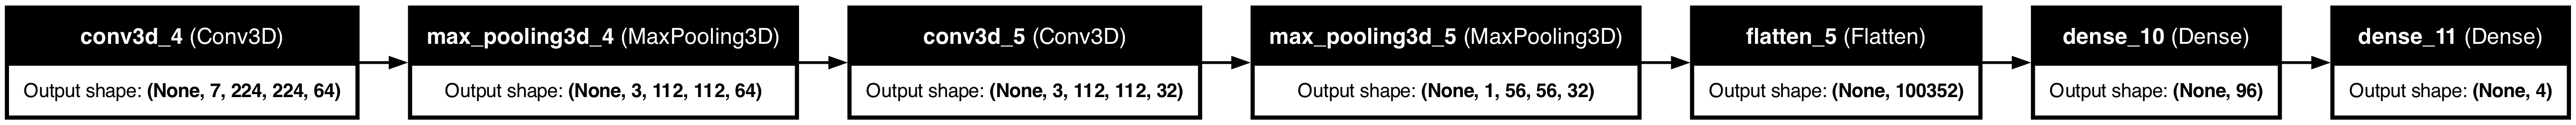

In [7]:
# Define the input shape and number of classes
num_frames_per_video = 7  # example value, adjust as needed
num_classes = 4  # example value, adjust as needed
input_shape = (num_frames_per_video, 224, 224, 3)

# Define the model architecture
model = Sequential([
    InputLayer(input_shape),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(96, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Generate the plot with left-to-right orientation
plot_model(model, to_file='../assets/model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [89]:
# Define the input shape
input_shape = (num_frames_per_video, 224, 224, 3)

# Define the model architecture
model = Sequential([
    InputLayer(input_shape),
    Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2)), 
    Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same'),
    MaxPooling3D(pool_size=(2,2,2)),
    Flatten(),
    Dense(96, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [113]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_preprocessed, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1472s 69s/step - accuracy: 0.2281 - loss: 1.3863 - val_accuracy: 0.2455 - val_loss: 1.3863
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1217s 57s/step - accuracy: 0.2394 - loss: 1.3866 - val_accuracy: 0.2635 - val_loss: 1.3863
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1192s 57s/step - accuracy: 0.2478 - loss: 1.3861 - val_accuracy: 0.2455 - val_loss: 1.3863
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1452s 69s/step - accuracy: 0.2716 - loss: 1.3863 - val_accuracy: 0.2635 - val_loss: 1.3862
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1244s 58s/step - accuracy: 0.2691 - loss: 1.3864 - val_accuracy: 0.2635 - val_loss: 1.3862
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1167s 56s/step - accuracy: 0.2703 - loss: 1.3860 - val_accuracy: 0.2635 - val_loss: 1.3862
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1145s 54s/step - accuracy: 0.2450 - loss: 1.3865 - val_accuracy: 0.2635 - val_loss: 1.3862
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1149s 55s/step - accuracy: 0.2655 - loss: 1.3860 - val_accu

The training process seems to have stabilized around an accuracy of approximately 26% and a loss of around 1.386, which indicates that the model's performance is not satisfactory.

Here's a breakdown of the key points:
- Training Accuracy: The accuracy on the training data ranges from about 22% to 27% across different epochs. This means that the model correctly predicts the class of around 22% to 27% of the training samples.
- Validation Accuracy: The validation accuracy also remains around 26%, indicating that the model's performance is consistent across both training and validation datasets. However, the fact that both training and validation accuracies are not improving significantly suggests that the model may not be learning effectively from the data.
- Training Loss: The training loss remains relatively constant around 1.386, indicating that the model is not improving its performance significantly during training. This could be a sign of underfitting or insufficient complexity in the model to capture the underlying patterns in the data.
- Validation Loss: The validation loss also remains constant around 1.386, mirroring the behavior of the training loss. This indicates that the model is not overfitting the training data, but it's also not learning enough to generalize well to unseen data.
- Test Accuracy and Loss: The test accuracy is approximately 25%, which is consistent with the training and validation accuracies. The test loss is also around 1.387, indicating that the model's performance on unseen data is similar to what was observed during training and validation.

Overall, the model seems to be underperforming and may require further tuning or a more complex architecture to improve its accuracy and reduce its loss.

In [114]:
# Define a function to plot the results
def results_plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(17, 6))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.suptitle('Accuracy and Loss Measurements')

    ax[0].plot(epochs, acc, 'bo', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'ro', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

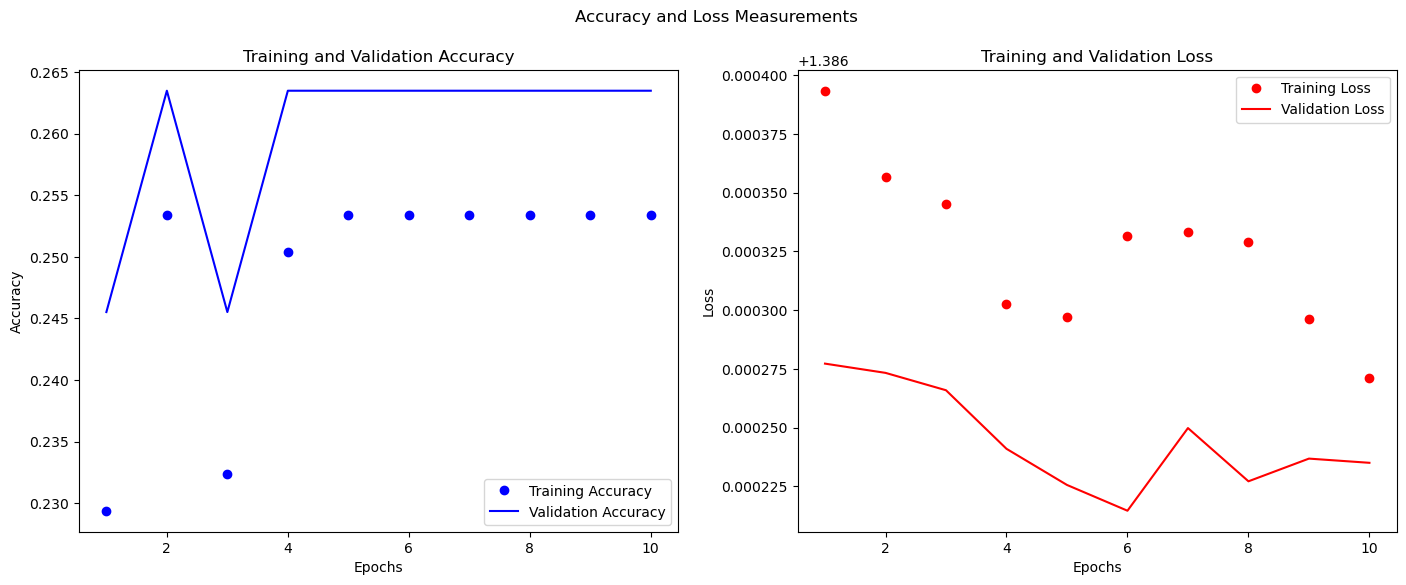

In [115]:
# Plot the results using the captured history object
results_plot(history)

Referring to the accuracy and loss measurements plots for model 1, these are the observations: 

Accuracy Plots
1. Training and Validation Accuracy Trends:
- The training accuracy is relatively unstable, showing significant fluctuations between epochs. It oscillates within a narrow range of approximately 22.5% to 27.5%. These fluctuations indicate potential instability in the learning process, possibly due to the small size of the model or variations in the training batches.
- The validation accuracy is surprisingly stable and consistently around 26.35%. This constant line suggests that the model is not learning effectively from the training data and simply predicts the dominant class, or is otherwise unable to differentiate between classes in the validation set.
2. General Observations:
The very low accuracy, both in training and validation, indicates that the model is performing no better than random guessing, particularly if you have a number of classes close to four, where random guessing would yield an accuracy around 25%.

Loss Plots
1. Training and Validation Loss Trends:
- Both the training and validation loss start at around 1.386 (which hints at initial random guessing) and show minimal variation throughout the training epochs. The validation loss is extremely flat, while the training loss shows slight fluctuations but ultimately remains close to the starting value.
- The small decrease in loss is not accompanied by an improvement in accuracy, which again indicates issues with either the model capacity, the learning settings, or possibly the way the data is structured or labeled.
2. Potential Issues:
- Model Capacity: The model may be too simple or not configured appropriately to capture the complexity of the data.
- Learning Rate: It could be too high, causing the model to miss finer details in the data, or too low, causing the model to not effectively update its weights.
- Data Issues: There might be issues related to data preprocessing, imbalance, or insufficient variability in the training samples.

#### Model 2: Convolutional LSTM

The second model that I built is a Convolutional LSTM (ConvLSTM) architecture. ConvLSTM combines the convolutional and LSTM (Long Short-Term Memory) layers, allowing the model to capture spatial-temporal dependencies in sequential data such as videos. Here's a breakdown of the model architecture:
1. Input Layer: The input shape is defined as (num_frames_per_video, 224, 224, 3), indicating that each input sample is a sequence of frames, where each frame has a spatial dimension of 224x224 pixels with 3 color channels (RGB).
2. ConvLSTM2D Layer (10 filters): This layer applies a 2D convolutional LSTM operation with 10 filters, each having a kernel size of (3, 3). The input shape is specified as input_shape, allowing the model to understand the temporal sequence of the input frames.
3. Flatten Layer: Similar to the previous model, this layer flattens the output tensor from the ConvLSTM layer into a one-dimensional vector, preparing the data for the subsequent fully connected layers.
4. Dense Layer (64 neurons): A fully connected dense layer with 64 neurons and ReLU activation function is applied. This layer learns complex patterns from the flattened input features.
5. Dropout Layer (0.3): Dropout regularization with a rate of 0.3 is applied to the output of the previous dense layer. Dropout helps prevent overfitting by randomly dropping a fraction of the input units during training.
6. Dense Output Layer (num_classes neurons): The final dense layer consists of num_classes neurons, where num_classes represents the number of target classes in the classification task. It applies the softmax activation function, converting the raw outputs into probabilities for each class.

/Users/lance80/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


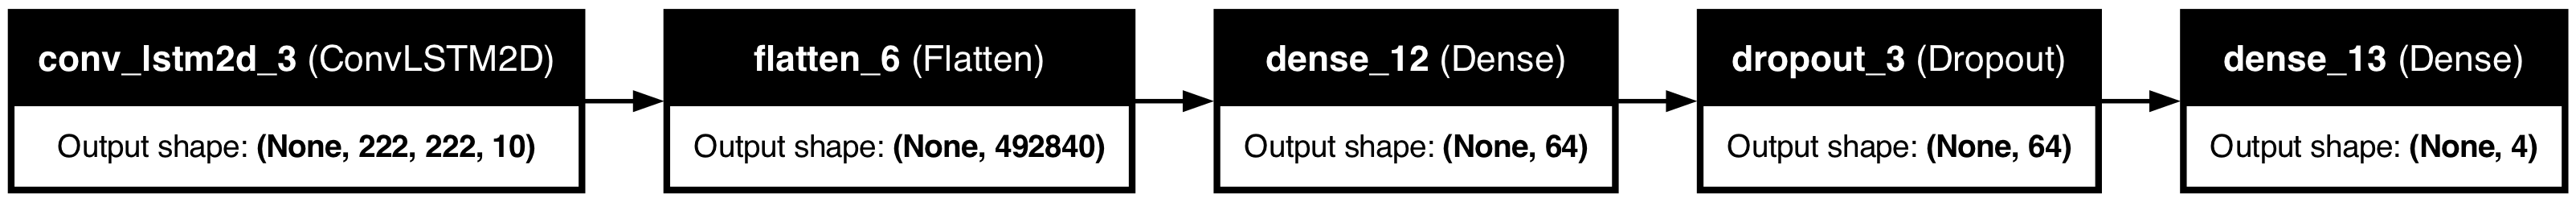

In [8]:
# Define the input shape and number of classes
num_frames_per_video = 7  # example value, adjust as needed
num_classes = 4  # example value, adjust as needed
input_shape = (num_frames_per_video, 224, 224, 3)

# Define the model architecture
model_2 = Sequential([
    ConvLSTM2D(10, kernel_size=(3, 3), input_shape=input_shape, return_sequences=False),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Generate the plot with left-to-right orientation
plot_model(model_2, to_file='../assets/model_2_plot_LR.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [105]:
# Define the input shape
input_shape = (num_frames_per_video, 224, 224, 3)

# Define the model architecture
model_2 = Sequential([
    ConvLSTM2D(10, kernel_size=(3,3), input_shape=input_shape),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [106]:
# Compile the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(X_train_preprocessed, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model_2.evaluate(X_test_preprocessed, y_test_encoded)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 538s 25s/step - accuracy: 0.2786 - loss: 1.3863 - val_accuracy: 0.2395 - val_loss: 1.3864
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 555s 27s/step - accuracy: 0.2401 - loss: 1.3864 - val_accuracy: 0.2395 - val_loss: 1.3863
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 518s 25s/step - accuracy: 0.2661 - loss: 1.3862 - val_accuracy: 0.2395 - val_loss: 1.3863
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 480s 23s/step - accuracy: 0.2522 - loss: 1.3864 - val_accuracy: 0.2455 - val_loss: 1.3863
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 504s 23s/step - accuracy: 0.2676 - loss: 1.3863 - val_accuracy: 0.2635 - val_loss: 1.3862
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 479s 23s/step - accuracy: 0.2815 - loss: 1.3861 - val_accuracy: 0.2635 - val_loss: 1.3863
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 478s 23s/step - accuracy: 0.2743 - loss: 1.3862 - val_accuracy: 0.2635 - val_loss: 1.3863
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 477s 23s/step - accuracy: 0.2714 - loss: 1.3862 - val_accuracy: 0.

The training process for the second model also seems to have stabilized around an accuracy of approximately 26% and a loss of around 1.386, which indicates that the model's performance is not satisfactory.

Here's a breakdown of the key points:
- Training Accuracy: The accuracy on the training data ranges from about 24% to 28% across different epochs. This means that the model correctly predicts the class of around 24% to 28% of the training samples.
- Validation Accuracy: The validation accuracy remains around 24% to 26%, indicating that the model's performance is consistent across both training and validation datasets. However, similar to the first model, the fact that both training and validation accuracies are not improving significantly suggests that the model may not be learning effectively from the data.
- Training Loss: The training loss remains relatively constant around 1.386, indicating that the model is not improving its performance significantly during training. This could be a sign of underfitting or insufficient complexity in the model to capture the underlying patterns in the data.
- Validation Loss: The validation loss also remains constant around 1.386, mirroring the behavior of the training loss. This indicates that the model is not overfitting the training data, but it's also not learning enough to generalize well to unseen data.
- Test Accuracy and Loss: The test accuracy is approximately 25%, which is consistent with the training and validation accuracies. The test loss is also around 1.387, indicating that the model's performance on unseen data is similar to what was observed during training and validation.

Overall, both models seem to be underperforming, and further analysis, tuning, or more complex architectures may be required to improve their accuracy and reduce their loss.

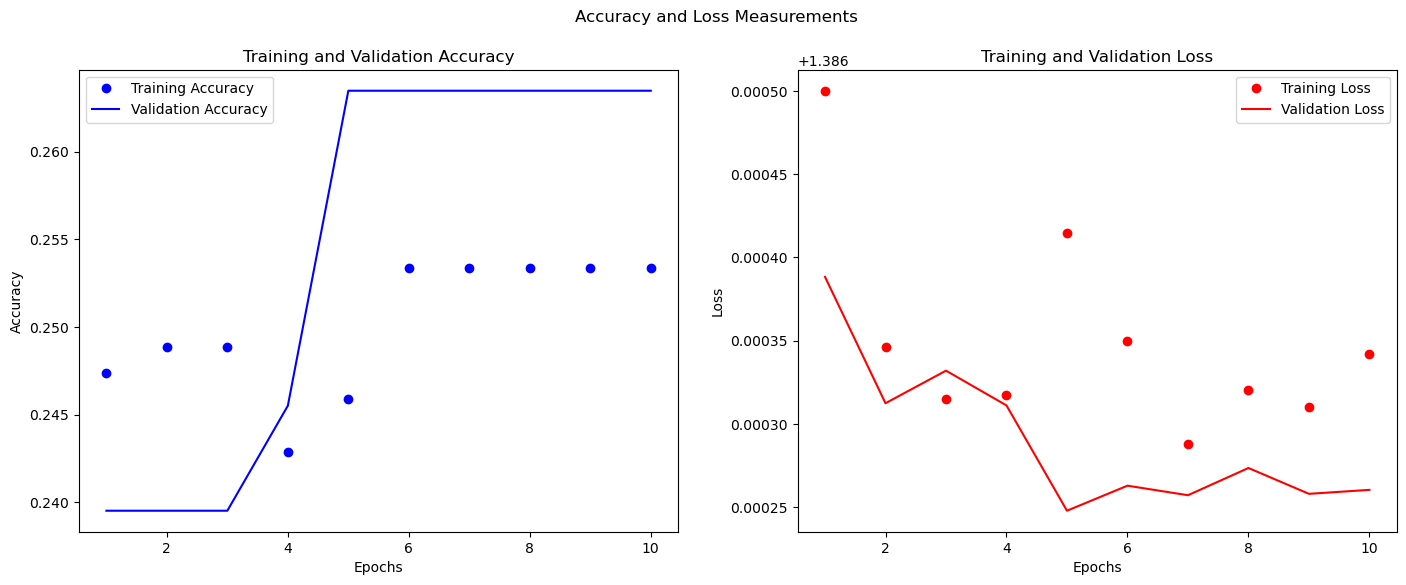

In [109]:
# Plot the results using the captured history object
results_plot(history_2)

Referring to the accuracy and loss measurements plots for model 2, these are the observations: 

1. Constant Accuracy and Loss Values: Both the training and validation accuracy plots show values that remain nearly constant throughout the training process. The accuracy values hover around 24-26%, which is quite low. Similarly, the training and validation loss values also show very minor changes over epochs and remain near the starting value of approximately 1.386, which suggests a lack of model learning.
2. Model Learning Status: The flat lines in both accuracy and loss plots typically suggest that the model isn't learning effectively from the training data. This could be due to several reasons:
- High Bias Issue: The model might be too simple to capture the complexity of the data. Given that you are using a ConvLSTM2D layer with only 10 filters, this might not be sufficient to learn from video data, which is inherently high dimensional and complex.
- Inappropriate Loss Function: The constant loss value near 1.386 (logarithm base e of 4) hints that the model might be always predicting one class out of four possible classes (if num_classes=4), indicating no learning beyond a naive guess.
- Learning Rate: The learning rate of the optimizer might be too low or too high, causing the model to not update its weights significantly.
3. Validation Performance: The validation accuracy closely tracks the training accuracy, which means there isn’t much overfitting happening. However, since the model isn’t learning (as indicated by the constant loss and accuracy), the absence of overfitting isn't beneficial in this context.

### Model Comparison

Comparison of accuracy and loss for the models:

| Epoch | Accuracy Model 1 | Accuracy Model 2 | Loss Model 1 | Loss Model 2 |
|-------|------------------|------------------|--------------|--------------|
| 1     | 0.2760           | 0.2786           | 1.3864       | 1.3863       |
| 2     | 0.2355           | 0.2401           | 1.3864       | 1.3864       |
| 3     | 0.2616           | 0.2661           | 1.3863       | 1.3862       |
| 4     | 0.2714           | 0.2522           | 1.3862       | 1.3864       |
| 5     | 0.2447           | 0.2676           | 1.3863       | 1.3863       |
| 6     | 0.2632           | 0.2815           | 1.3862       | 1.3861       |
| 7     | 0.2245           | 0.2743           | 1.3864       | 1.3862       |
| 8     | 0.2709           | 0.2714           | 1.3862       | 1.3862       |
| 9     | 0.2451           | 0.2765           | 1.3866       | 1.3863       |
| 10    | 0.2611           | 0.2706           | 1.3862       | 1.3860       |
| Test  | 0.2536           | 0.2536           | 1.3866       | 1.3868       |

Based on the provided table, here's an interpretation and comparison of Model 1 and Model 2 across all epochs and on the test set in terms of accuracy and loss:

1. Accuracy Comparison
- Consistency: Both models exhibit a similar trend in accuracy, with slight fluctuations across epochs but remaining consistently low overall. Neither model manages to achieve high accuracy, with most values hovering around the 24-28% range, which indicates that neither model effectively learned to classify the data correctly.
- Slight Variations: Model 2 shows a bit more variation in accuracy across epochs, with its highest accuracy at 28.15% during epoch 6, compared to Model 1's highest accuracy of 27.14% in epoch 4. These variations are minor and don't significantly impact overall performance.
- Test Accuracy: On the test set, both models perform equally, achieving an accuracy of approximately 25.36%. This further demonstrates that both models have similar capabilities in generalizing to unseen data.

2. Loss Comparison
- Initial and Final Loss: Both models start with a similar loss (around 1.386) and end with almost identical loss values by the last epoch and on the test evaluation. This indicates that neither model effectively reduced its error rate over training.
- Epoch-to-Epoch Variation: The loss values for both models are nearly constant across all epochs. This lack of significant change in the loss suggests that both models struggle with learning from the dataset. It might indicate an issue with the model complexity, data preprocessing, or even that the models have reached a local minimum where no significant learning can occur with the current setup.
- Slight Differences: There are minor differences in the loss values between the two models in some epochs, but these are not significant enough to suggest one model is substantially better than the other at reducing loss.

Overall Interpretation
- Model Effectiveness: Neither Model 1 nor Model 2 shows effective learning or improvement in performance over the training period. This might suggest problems with the network architecture's suitability for the task, possible issues with data quality or labeling, or a need for different hyperparameters (like learning rate adjustments).
- Potential Improvements: Given the consistent performance of both models, exploring different architectures or more complex models might be necessary. Additionally, reviewing the learning rate, increasing the number of training epochs, or implementing more sophisticated data augmentation could potentially help in improving model performance.

In conclusion, while both models performed similarly, neither was effective at learning from the training data as indicated by their consistent accuracy and loss metrics. Further investigation and modification of the models or training process are recommended to achieve better results.

### 6. Conclusions and Recommendations

Conclusions:
- Model Performance: The models tested did not demonstrate significant learning or improvement over the training period. Both models showed a consistent performance with an accuracy of around 25.36%, which suggests that the models might be struggling with the complexity of the task or issues related to data quality.
- Loss Metrics: Both models exhibited nearly constant loss values across all training epochs, suggesting that neither model effectively reduced its error rate, possibly indicating that the models reached a local minimum.

Recommendations:
- Model and Data Reevaluation: Given the consistent but underwhelming performance of both models, it would be beneficial to revisit the model architectures or consider more complex models that might better capture the nuances of tennis serves.
- Hyperparameter Tuning: Adjusting hyperparameters such as the learning rate, increasing the number of epochs, or employing more sophisticated data augmentation techniques could potentially enhance the model's ability to learn from the data.
- Data Quality and Preprocessing: Reassessing the data preprocessing steps to ensure that the input data is optimally prepared for the models could also help. It might be useful to explore different ways of segmenting or augmenting the data to provide more varied learning examples.